# ML818 RL | CW2

Hugo Touchette

Started: 5 July 2022

Last updated: 11 July 2022

Python 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym_minigrid
from gym_minigrid.wrappers import *
import hashlib
import base64
import glob
import io
from IPython.display import HTML 
from IPython import display
%config InlineBackend.figure_format = 'svg'

## Functions

In [2]:
def extractObjectInformation(observation):
    (rows, cols, x) = obs.shape
    tmp = np.reshape(obs,[rows*cols*x,1], 'F')[0:rows*cols]
    return np.reshape(tmp, [rows,cols],'F')

In [3]:
def hashState(state):
    return hashlib.sha1(state.tobytes()).hexdigest()

In [4]:
def show_video(folder):
    mp4list = glob.glob(folder+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

## Simulation

10.0% done | Reward =  0.75 | No steps =  70
20.0% done | Reward =  0.79 | No steps =  60
30.0% done | Reward =  0.81 | No steps =  55
40.0% done | Reward =  0.89 | No steps =  32
50.0% done | Reward =  0.80 | No steps =  57
60.0% done | Reward =  0.79 | No steps =  61
70.0% done | Reward =  0.95 | No steps =  13
80.0% done | Reward =  0.94 | No steps =  18
90.0% done | Reward =  0.94 | No steps =  16


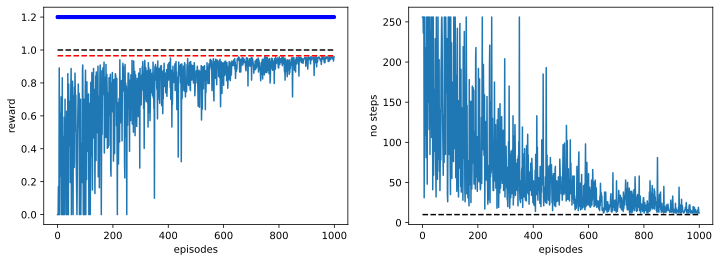

In [81]:
# Parameters
episodes = 1000
max_steps = 500
epsmax = 0.9
epsmin = 0.1
gamma = 0.55
alpha = 0.15
nactions = 3
verboseFlag = True

# Containers
Q = {}
rewardlist = np.zeros(episodes)
reachedlist = np.zeros(episodes)
stepcountlist = np.zeros(episodes)
deps = (epsmax - epsmin)/episodes
plt.figure(figsize=(12, 4))

# Load environment
env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(env)

# First observation
obs = env.reset()
currentState = extractObjectInformation(obs)
currentStateKey = hashState(currentState)
Q[currentStateKey] = np.zeros(nactions)  

# Training
for e in range(episodes):
    eps = epsmax - e*deps
    obs = env.reset()
    cumreward = 0
    stepcount = 0

    for i in range(max_steps):

        # epsilon greedy action
        if np.random.random() < eps:
            a = np.random.randint(0, nactions)
        else:
            a = np.argmax(Q[currentStateKey])

        # Forward step
        obs, reward, done, info = env.step(a)
        nextState = extractObjectInformation(obs)
        nextStateKey = hashState(nextState)
        cumreward += reward

        # Initialise key if seen first time
        if nextStateKey not in Q:
            Q[nextStateKey] = np.zeros(nactions)
        
        # Q learning
        maxQ = np.max(Q[nextStateKey])
        Q[currentStateKey][a] = (1-alpha)*Q[currentStateKey][a] + alpha*(reward + gamma*maxQ)
        currentState = nextState
        currentStateKey = nextStateKey
        stepcount += 1

        # Stopping rule
        if done:
            reachedlist[e] = 1.2
            break

    rewardlist[e] = cumreward
    stepcountlist[e] = stepcount
    
    # Progress
    if verboseFlag:
        if e > 0 and (e % (episodes/10) == 0):
            print(str(e/episodes*100)+'% done |', 'Reward = %5.2f |' % cumreward, 'No steps = ', stepcount)

plt.subplot(1,2,1)
plt.plot(range(episodes), rewardlist)
plt.plot(range(episodes), np.ones(episodes), 'k--')
plt.plot(range(episodes), np.ones(episodes)-0.9*10/256, 'r--')
plt.plot(range(episodes), reachedlist, 'b.')
plt.xlabel('episodes')
plt.ylabel('reward')

plt.subplot(1,2,2)
plt.plot(range(episodes), stepcountlist)
plt.plot(range(episodes), np.ones(episodes)*10, 'k--')
plt.xlabel('episodes')
plt.ylabel('no steps')
plt.show()

## Hyperparameter tuning

In [70]:
# Parameters
nrepetitions = 100
episodes = 1000
max_steps = 500
nactions = 3

epsmax = 0.8
epsmin = 0.1

# Hyperparameters searched
gammaa = 0.4
gammab = 0.6
ngamma = 10

alphaa = 0.15
alphab = 0.15
nalpha = 1

# Containers
deps = (epsmax - epsmin)/episodes
gammarange = np.linspace(gammaa, gammab, ngamma)
dgamma = (gammab - gammaa)/ngamma
alpharange = np.linspace(alphaa, alphab, nalpha)
dalpha = (alphab - alphaa)/nalpha
fullresults = np.zeros((ngamma, nalpha))

# Load environment
env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(env)

currentmax = -5.0
posmax = [0, 0]
progctr = 0

for igamma, gamma in enumerate(gammarange):
    for jalpha, alpha in enumerate(alpharange):
        meanrew = 0.0
        for n in range(nrepetitions):
            Q = {}
    
            # First observation
            obs = env.reset()
            currentState = extractObjectInformation(obs)
            currentStateKey = hashState(currentState)
            Q[currentStateKey] = np.zeros(nactions)  

            # Training
            for e in range(episodes):
                eps = epsmax - e*deps
                obs = env.reset()
                cumreward = 0

                for i in range(max_steps):

                    # epsilon greedy action
                    if np.random.random() < eps:
                        a = np.random.randint(0, nactions)
                    else:
                        a = np.argmax(Q[currentStateKey])

                    # Forward step
                    obs, reward, done, info = env.step(a)
                    nextState = extractObjectInformation(obs)
                    nextStateKey = hashState(nextState)
                    cumreward += reward

                    # Initialise key if seen for the first time
                    if nextStateKey not in Q:
                        Q[nextStateKey] = np.zeros(nactions)
        
                    # Q learning
                    maxQ = np.max(Q[nextStateKey])
                    Q[currentStateKey][a] = (1-alpha)*Q[currentStateKey][a] + alpha*(reward + gamma*maxQ)
                    currentState = nextState
                    currentStateKey = nextStateKey

                    # Stopping rule
                    if done:
                        break

            meanrew += cumreward
                
        meanrew /= nrepetitions
        fullresults[igamma,jalpha] = meanrew
        if meanrew > currentmax:
            currentmax = meanrew
            posmax[0] = igamma
            posmax[1] = jalpha
          
        # Progress
        progctr += 1
        print(str(int(progctr/(ngamma*nalpha)*100))+'% done.')

# Results
print(' ')
print('Max =', currentmax)
print('Theoretical max =', 1-0.9*10/256)
print('epsmin =', epsmin)
print('epsmax =', epsmax)
print('Optimal gamma =', gammaa+posmax[0]*dgamma)
print('Optimal alpha =', alphaa+posmax[1]*dalpha)

10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
 
Max = 0.9498320312500006
Theoretical max = 0.96484375
epsmin = 0.1
epsmax = 0.8
Optimal gamma = 0.58
Optimal alpha = 0.15


Test 1: $\gamma=0.4$, $\alpha = 0.1$. Both lower bounds of range so need to change range.

Test 2: $\gamma=0.42$, $\alpha = 0.15$. Reduce range. 

Test 3: $\gamma=0.48$, $\alpha =0.17$. Upper bounds of range. Augment ranges and add more points.

Test 4: $\gamma = 0.56$, $\alpha = 0.14$. Loop over $\gamma$ only with more repetitions.

Test 5: $\gamma = 0.58$, $\alpha =0.15$. 

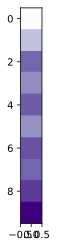

[[0.94160547]
 [0.94445313]
 [0.94723047]
 [0.94610547]
 [0.94751172]
 [0.946     ]
 [0.94775781]
 [0.94726563]
 [0.94832031]
 [0.94983203]] [9, 0]


In [80]:
plt.imshow(fullresults, 'Purples')
plt.show()
print(fullresults, posmax)

## Trained agent

In [82]:
eps = 0.1
folder = 'minigridrecording'
env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(env)
env = gym.wrappers.Monitor(env, folder, force=True)
obs = env.reset()

while True:
    state = extractObjectInformation(obs)
    stateKey = hashState(state)

    if np.random.random() < eps:
        a = np.random.randint(0, nactions)
    else:
        a = np.argmax(Q[stateKey])

    obs, rew, done, info = env.step(a)
    if done:
        break
        
env.close()
show_video(folder)